### Шаг 1. Откройте файлы с данными

#### Описание проекта ####

Зaказчик этого исследования — сеть отелей «Как в гостях». 

Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.


Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. 

Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

#### Импорт библиотек ####

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score,
    f1_score, 
    precision_score, 
    recall_score,
    roc_curve
    
)

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import joblib

#import folium
#from folium.plugins import HeatMap
#import plotly.express as px


import warnings
warnings.filterwarnings("ignore")# отключаем предупреждения



In [2]:
pd.set_option('display.max_columns', None) # настроим в выоде показ всех колонок

In [3]:
hotel_train = pd.read_csv('/datasets/hotel_train.csv') # читаем наши данные. Сначала тренировочная выборка, далее - тестовая
hotel_test = pd.read_csv('/datasets/hotel_test.csv')

In [4]:
hotel_train.name = 'Информация по обучаещему датасету'
hotel_test.name = 'Информация по тествому датасету'

In [5]:
def info(data):
    print(data.name)
    display(data.head(10))
    display(data.describe(include = 'all').T)
    display(data.info())
    print('Количество дубликатов:', data.duplicated().sum())
    
    print(f'''Пропусков: 
    
{ 100* (data.isna().sum()/ data.shape[0])}''')
    return
    

In [6]:
info(hotel_test)

Информация по тествому датасету


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7
5,6091,1,52.0,2017,January,1,1,2,5,1.0,0.0,0.0,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,0,7
6,6092,1,143.0,2017,January,1,2,1,1,2.0,0.0,0.0,BB,BRA,Direct,0,0,0,A,1,0,Transient,0,1,2
7,6093,1,21.0,2017,January,1,2,1,3,2.0,0.0,0.0,BB,BRA,TA/TO,0,0,0,A,0,0,Transient,0,1,4
8,6094,1,89.0,2017,January,1,2,1,3,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,E,0,0,Transient,0,0,4
9,6095,1,48.0,2017,January,1,2,1,4,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,A,1,0,Transient,0,2,5


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,32412.0,NaN,NaN,NaN,60131.505183,29953.586177,6086.0,45291.75,53394.5,89800.25,97903.0
is_canceled,32412.0,NaN,NaN,NaN,0.388467,0.487409,0.0,0.0,0.0,1.0,1.0
lead_time,32412.0,NaN,NaN,NaN,97.587869,86.507146,0.0,23.0,76.0,155.0,373.0
arrival_date_year,32412.0,NaN,NaN,NaN,2017.0,0.0,2017.0,2017.0,2017.0,2017.0,2017.0
arrival_date_month,32412,8,May,5262,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival_date_week_number,32412.0,NaN,NaN,NaN,17.804054,9.177384,1.0,10.0,18.0,25.0,35.0
arrival_date_day_of_month,32412.0,NaN,NaN,NaN,15.656948,8.766429,1.0,8.0,15.5,23.0,31.0
stays_in_weekend_nights,32412.0,NaN,NaN,NaN,0.867888,0.853394,0.0,0.0,1.0,2.0,4.0
stays_in_week_nights,32412.0,NaN,NaN,NaN,2.34009,1.37517,0.0,1.0,2.0,3.0,6.0
adults,32412.0,NaN,NaN,NaN,1.858602,0.489341,0.0,2.0,2.0,2.0,4.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

None

Количество дубликатов: 0
Пропусков: 
    
id                                0.0
is_canceled                       0.0
lead_time                         0.0
arrival_date_year                 0.0
arrival_date_month                0.0
arrival_date_week_number          0.0
arrival_date_day_of_month         0.0
stays_in_weekend_nights           0.0
stays_in_week_nights              0.0
adults                            0.0
children                          0.0
babies                            0.0
meal                              0.0
country                           0.0
distribution_channel              0.0
is_repeated_guest                 0.0
previous_cancellations            0.0
previous_bookings_not_canceled    0.0
reserved_room_type                0.0
booking_changes                   0.0
days_in_waiting_list              0.0
customer_type                     0.0
required_car_parking_spaces       0.0
total_of_special_requests         0.0
total_nights                      0.0
dtype: f

In [7]:
info(hotel_train)

Информация по обучаещему датасету


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3
5,5,1,75.0,2015,July,27,1,0,3,2.0,0.0,0.0,HB,PRT,TA/TO,0,0,0,D,0,0,Transient,0,0,3
6,6,1,23.0,2015,July,27,1,0,4,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,E,0,0,Transient,0,0,4
7,7,0,18.0,2015,July,27,1,0,4,2.0,1.0,0.0,HB,ESP,TA/TO,0,0,0,G,1,0,Transient,0,1,4
8,8,0,68.0,2015,July,27,1,0,4,2.0,0.0,0.0,BB,IRL,TA/TO,0,0,0,D,0,0,Transient,0,3,4
9,9,0,37.0,2015,July,27,1,0,4,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,E,0,0,Contract,0,0,4


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,65229.0,NaN,NaN,NaN,43544.069172,25614.858971,0.0,19108.0,40554.0,67414.0,84121.0
is_canceled,65229.0,NaN,NaN,NaN,0.368609,0.482431,0.0,0.0,0.0,1.0,1.0
lead_time,65229.0,NaN,NaN,NaN,96.337917,96.127545,0.0,17.0,64.0,151.0,374.0
arrival_date_year,65229.0,NaN,NaN,NaN,2015.719021,0.449481,2015.0,2015.0,2016.0,2016.0,2016.0
arrival_date_month,65229,12,October,9255,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival_date_week_number,65229.0,NaN,NaN,NaN,31.339772,13.464024,1.0,21.0,34.0,42.0,53.0
arrival_date_day_of_month,65229.0,NaN,NaN,NaN,15.847813,8.748182,1.0,8.0,16.0,23.0,31.0
stays_in_weekend_nights,65229.0,NaN,NaN,NaN,0.825185,0.853477,0.0,0.0,1.0,2.0,4.0
stays_in_week_nights,65229.0,NaN,NaN,NaN,2.224793,1.354992,0.0,1.0,2.0,3.0,6.0
adults,65229.0,NaN,NaN,NaN,1.836576,0.480245,0.0,2.0,2.0,2.0,4.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

None

Количество дубликатов: 0
Пропусков: 
    
id                                0.0
is_canceled                       0.0
lead_time                         0.0
arrival_date_year                 0.0
arrival_date_month                0.0
arrival_date_week_number          0.0
arrival_date_day_of_month         0.0
stays_in_weekend_nights           0.0
stays_in_week_nights              0.0
adults                            0.0
children                          0.0
babies                            0.0
meal                              0.0
country                           0.0
distribution_channel              0.0
is_repeated_guest                 0.0
previous_cancellations            0.0
previous_bookings_not_canceled    0.0
reserved_room_type                0.0
booking_changes                   0.0
days_in_waiting_list              0.0
customer_type                     0.0
required_car_parking_spaces       0.0
total_of_special_requests         0.0
total_nights                      0.0
dtype: f

**Вывод**

Мы видим, что присутсвют пробелы в столбцах meal, distribution_channel.

 Удалим строки с нулевым количеством постояльцев и Столбец id, так как он нам не нужен.

### Шаг 2. Предобработка и исследовательский анализ данных

In [8]:
#Удаляем id
hotel_train.drop(columns='id', inplace=True)
hotel_test.drop(columns='id', inplace=True)

In [9]:
print('Количество дубликатов в обучающем датафрейме:', hotel_train.duplicated().sum())
print('Количество дубликатов в тестовом датафрейме:', hotel_test.duplicated().sum())

Количество дубликатов в обучающем датафрейме: 21377
Количество дубликатов в тестовом датафрейме: 7717


In [10]:
hotel_train.shape

(65229, 24)

In [11]:
hotel_test.shape

(32412, 24)

Проверим, идентичны ли типы данных в этих датасетах.

In [12]:
hotel_train.dtypes == hotel_test.dtypes

is_canceled                       True
lead_time                         True
arrival_date_year                 True
arrival_date_month                True
arrival_date_week_number          True
arrival_date_day_of_month         True
stays_in_weekend_nights           True
stays_in_week_nights              True
adults                            True
children                          True
babies                            True
meal                              True
country                           True
distribution_channel              True
is_repeated_guest                 True
previous_cancellations            True
previous_bookings_not_canceled    True
reserved_room_type                True
booking_changes                   True
days_in_waiting_list              True
customer_type                     True
required_car_parking_spaces       True
total_of_special_requests         True
total_nights                      True
dtype: bool

Изменим тип данных в столбцах 'lead_time','adults' , 'children' , 'babies'  на int.

In [13]:
hotel_train[['lead_time','adults' , 'children' , 'babies']] = hotel_train[['lead_time','adults' , 'children' , 'babies']].astype('int64')


In [14]:
hotel_train.dtypes

is_canceled                        int64
lead_time                          int64
arrival_date_year                  int64
arrival_date_month                object
arrival_date_week_number           int64
arrival_date_day_of_month          int64
stays_in_weekend_nights            int64
stays_in_week_nights               int64
adults                             int64
children                           int64
babies                             int64
meal                              object
country                           object
distribution_channel              object
is_repeated_guest                  int64
previous_cancellations             int64
previous_bookings_not_canceled     int64
reserved_room_type                object
booking_changes                    int64
days_in_waiting_list               int64
customer_type                     object
required_car_parking_spaces        int64
total_of_special_requests          int64
total_nights                       int64
dtype: object

In [15]:
hotel_test[['lead_time','adults' , 'children' , 'babies']] = hotel_test[['lead_time','adults' , 'children' , 'babies']].astype('int64')


In [16]:
hotel_test.dtypes

is_canceled                        int64
lead_time                          int64
arrival_date_year                  int64
arrival_date_month                object
arrival_date_week_number           int64
arrival_date_day_of_month          int64
stays_in_weekend_nights            int64
stays_in_week_nights               int64
adults                             int64
children                           int64
babies                             int64
meal                              object
country                           object
distribution_channel              object
is_repeated_guest                  int64
previous_cancellations             int64
previous_bookings_not_canceled     int64
reserved_room_type                object
booking_changes                    int64
days_in_waiting_list               int64
customer_type                     object
required_car_parking_spaces        int64
total_of_special_requests          int64
total_nights                       int64
dtype: object

In [17]:
#проверим на скрытые дубликаты
for column in hotel_train:
    print(sorted(hotel_train[column].unique()))
    print(f'Количество уникальных значений {column}:', hotel_train[column].nunique())

[0, 1]
Количество уникальных значений is_canceled: 2
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 2

In [18]:
for column in hotel_test:
    print(sorted(hotel_test[column].unique()))
    print(f'Количество уникальных значений {column}:', hotel_test[column].nunique())

[0, 1]
Количество уникальных значений is_canceled: 2
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 2


В столбце "meal" и "distribution_channel"  присутсвуют пробелы, из-за чего числа уникальных значений не совпадают с заявленными. 

In [19]:
combine_data = [hotel_train , hotel_test]
for data in combine_data :
    for column in ['meal', 'reserved_room_type']:
        data[column] = data[column].str.strip()
        print(data[column].unique())
        print(f'Количество уникальных значений {column}:', data[column].nunique())

['BB' 'FB' 'HB' 'SC']
Количество уникальных значений meal: 4
['A' 'C' 'D' 'E' 'G' 'F' 'B']
Количество уникальных значений reserved_room_type: 7
['BB' 'HB' 'SC' 'FB']
Количество уникальных значений meal: 4
['A' 'E' 'G' 'D' 'F' 'C' 'B']
Количество уникальных значений reserved_room_type: 7


In [20]:
def corr_matrix(hotel_train):    
    corr_matrix = hotel_train.corr()
    display(corr_matrix)
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="Reds");
    plt.show()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
is_canceled,1.000000,0.328142,-0.030835,0.012869,-0.001903,-0.013767,0.010650,0.045153,-0.017746,-0.029589,-0.040242,0.153023,-0.045557,-0.142935,0.075848,-0.186486,-0.257061,0.001542
lead_time,0.328142,1.000000,-0.022997,0.091603,-0.010252,0.047003,0.172646,0.119617,-0.056359,-0.024649,-0.089424,0.142454,-0.061690,-0.007191,0.209741,-0.116867,-0.147738,0.157671
arrival_date_year,-0.030835,-0.022997,1.000000,-0.388003,0.009789,-0.006474,0.013744,0.029102,0.052613,-0.007381,-0.005957,-0.134027,0.040137,0.041387,0.027224,0.014875,0.089731,0.007535
arrival_date_week_number,0.012869,0.091603,-0.388003,1.000000,0.048372,0.034029,0.032295,0.005638,-0.007255,0.003938,-0.013471,0.006870,-0.011915,0.011799,-0.052976,-0.007533,0.076650,0.041886
arrival_date_day_of_month,-0.001903,-0.010252,0.009789,0.048372,1.000000,-0.002017,0.003705,0.006034,0.018558,-0.000482,-0.010605,-0.032019,-0.000973,0.022560,0.017070,0.003816,0.005875,0.001898
stays_in_weekend_nights,-0.013767,0.047003,-0.006474,0.034029,-0.002017,1.000000,0.197410,0.116679,0.026224,0.018822,-0.081943,-0.008727,-0.025560,0.023118,-0.065167,-0.015870,0.083682,0.644935
stays_in_week_nights,0.010650,0.172646,0.013744,0.032295,0.003705,0.197410,1.000000,0.119901,0.023590,0.018428,-0.094617,-0.006098,-0.049188,0.061721,0.036037,-0.026988,0.090359,0.876515
adults,0.045153,0.119617,0.029102,0.005638,0.006034,0.116679,0.119901,1.000000,-0.003216,0.019756,-0.157053,0.003083,-0.115353,-0.056396,-0.013475,0.013321,0.171793,0.150766
children,-0.017746,-0.056359,0.052613,-0.007255,0.018558,0.026224,0.023590,-0.003216,1.000000,0.018410,-0.026707,-0.027357,-0.015807,0.053835,-0.038615,0.047881,0.112699,0.031268
babies,-0.029589,-0.024649,-0.007381,0.003938,-0.000482,0.018822,0.018428,0.019756,0.018410,1.000000,-0.011282,-0.008657,-0.005947,0.076910,-0.013391,0.030264,0.098973,0.023608


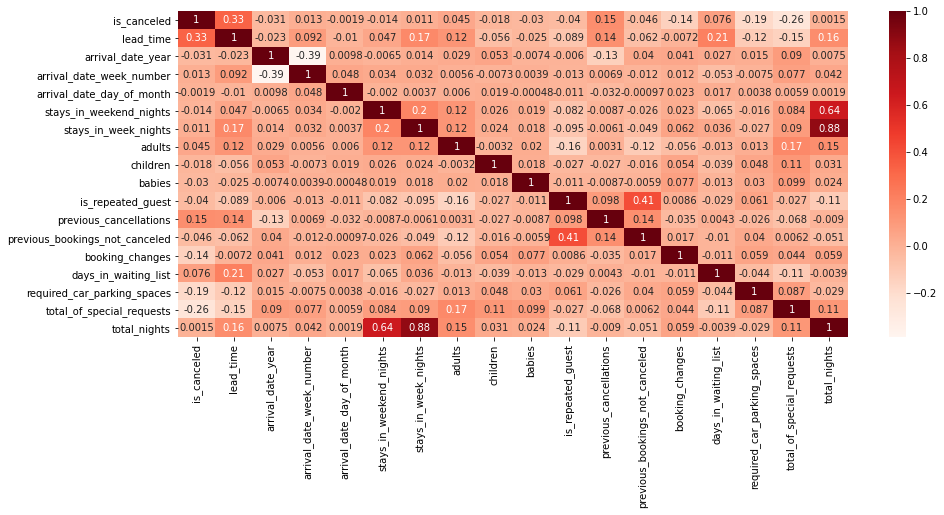

In [21]:
corr_matrix(hotel_train)

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
is_canceled,1.000000,0.238844,NaN,0.037331,-0.008966,-0.002269,0.047363,0.077144,0.012774,-0.038884,-0.125657,-0.032993,-0.065467,-0.137758,0.018361,-0.168035,-0.217377,0.036347
lead_time,0.238844,1.000000,NaN,0.344926,0.033666,0.162743,0.290421,0.183892,0.054764,0.002890,-0.169374,-0.058816,-0.089614,0.034083,0.065440,-0.097086,0.030730,0.309580
arrival_date_year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival_date_week_number,0.037331,0.344926,NaN,1.000000,0.124668,0.063705,0.083187,0.119440,0.032536,-0.003458,-0.062687,-0.008091,-0.011487,0.020593,-0.012678,-0.038426,0.063478,0.097063
arrival_date_day_of_month,-0.008966,0.033666,NaN,0.124668,1.000000,0.002631,-0.028789,-0.018421,0.005589,-0.003791,0.005226,0.002476,0.007951,-0.001654,-0.005593,0.011347,-0.007256,-0.021478
stays_in_weekend_nights,-0.002269,0.162743,NaN,0.063705,0.002631,1.000000,0.171974,0.102589,0.047861,0.021308,-0.089929,-0.035524,-0.052578,0.013325,0.010750,-0.029331,0.042969,0.626847
stays_in_week_nights,0.047363,0.290421,NaN,0.083187,-0.028789,0.171974,1.000000,0.141751,0.037734,0.030541,-0.115294,-0.036659,-0.058180,0.043919,0.016881,-0.048050,0.035584,0.875336
adults,0.077144,0.183892,NaN,0.119440,-0.018421,0.102589,0.141751,1.000000,-0.004425,0.019401,-0.202241,-0.102307,-0.138176,-0.061588,-0.003899,-0.014959,0.121337,0.162469
children,0.012774,0.054764,NaN,0.032536,0.005589,0.047861,0.037734,-0.004425,1.000000,0.026094,-0.029983,-0.015677,-0.020139,0.040325,-0.013518,0.028024,0.068811,0.053336
babies,-0.038884,0.002890,NaN,-0.003458,-0.003791,0.021308,0.030541,0.019401,0.026094,1.000000,-0.001440,-0.002429,-0.005578,0.087872,-0.004041,0.038471,0.067000,0.034614


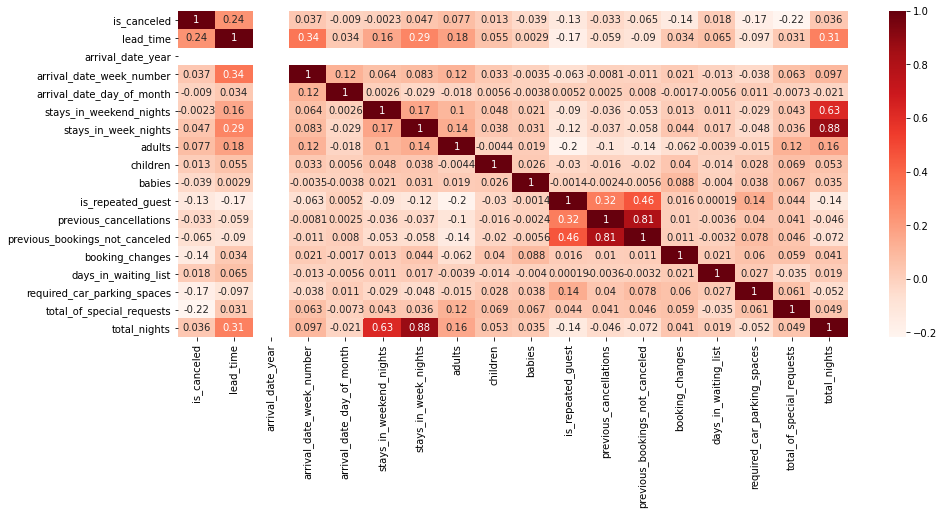

In [22]:
corr_matrix(hotel_test)

Время выполнения заказа (lead time) наиболее тесно связано с отмененой бронирования.



In [23]:
combine_data = [hotel_train , hotel_test]
for data in combine_data :
    is_can = len(data[data['is_canceled']==1])
    print("Процент отмены = ", is_can/len(data))
    

Процент отмены =  0.3686090542550093
Процент отмены =  0.3884672343576453


**Вавод**

Можем заметить зависимость между количеством заказов и повторным бронированием.

In [24]:
display(hotel_train['adults'].value_counts().to_frame())
display(hotel_train['children'].value_counts().to_frame())
display(hotel_train['babies'].value_counts().to_frame())

,adults
2,48980
1,13212
3,2858
0,166
4,13


,children
0,61712
1,2165
2,1336
3,16


,babies
0,64777
1,447
2,3
9,1
10,1


In [25]:
zero_train = hotel_train.loc[(hotel_train['adults'] == 0) & (hotel_train['children'] == 0), 'adults']
print('Без постоятельцев в hotel_train:', zero_train.count())

Без постоятельцев в hotel_train: 15


In [26]:
zero_test = hotel_test.loc[(hotel_test['adults'] == 0) & (hotel_test['children'] == 0), 'adults']
print('Без постоятельств в hotel_test:', zero_test.count())

Без постоятельств в hotel_test: 7


In [27]:

#Удаляем строки с нулевым количеством постояльцев
hotel_train = hotel_train.drop(zero_train.index).reset_index(drop=True)
hotel_test = hotel_test.drop(zero_test.index).reset_index(drop=True)

In [28]:
without_adults_train = hotel_train.loc[(hotel_train['adults'] == 0) & (hotel_train['babies'] > 0), 'babies']
print('Без взрослых в hotel_train:', without_adults_train.count())

Без взрослых в hotel_train: 3


In [29]:
without_adults_test = hotel_test.loc[(hotel_test['adults'] == 0) & (hotel_test['babies'] > 0) ,'babies']
print('Без взрослых в hotel_train:', without_adults_test.count())

Без взрослых в hotel_train: 0


In [30]:
hotel_train = hotel_train.drop(without_adults_train.index).reset_index(drop=True)


In [31]:
hotel_train.shape

(65211, 24)

In [32]:
hotel_test.shape

(32405, 24)

In [33]:
hotel_test.isna().sum()

is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64

In [34]:
hotel_test.isna().sum()

is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64

После удаления столбца id обнаружилось значительно количество полных дубликатов. Выяснить мы никак не можем, поэтому данные не удаляем.

In [35]:
#hotel_train.drop_duplicates(inplace=True, ignore_index=True)
#hotel_test.drop_duplicates(inplace=True, ignore_index=True)

In [36]:
print(f'Дубликатов в hotel_train: {round(hotel_train.duplicated().mean() * 100, 2)}%')
print(f'Дубликатов в hotel_test: {round(hotel_test.duplicated().mean() * 100, 2)}%')

Дубликатов в hotel_train: 32.78%
Дубликатов в hotel_test: 23.81%


In [37]:
print(hotel_train.arrival_date_month.value_counts())

October      9255
September    8782
August       6674
November     5756
July         5717
December     5494
April        4803
May          4675
June         4658
March        4148
February     3357
January      1892
Name: arrival_date_month, dtype: int64


In [38]:
print(hotel_test.arrival_date_month.value_counts())

May         5261
April       4878
June        4578
March       4275
July        3624
February    3543
January     3150
August      3096
Name: arrival_date_month, dtype: int64


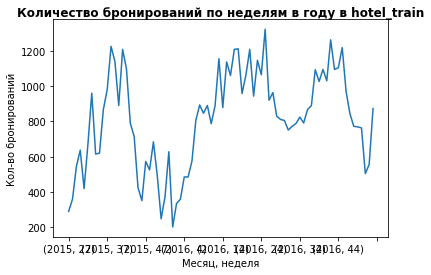

In [39]:

    hotel_train.pivot_table(index=['arrival_date_year', 'arrival_date_week_number'],
                            values='is_canceled', aggfunc='count').plot(legend=None)
    plt.xlabel('Месяц, неделя')
    plt.ylabel('Кол-во бронирований')
    plt.title(label='Количество бронирований по неделям в году в hotel_train' , 
          fontweight="bold", 
          pad='2.0',
          )
    plt.show() 

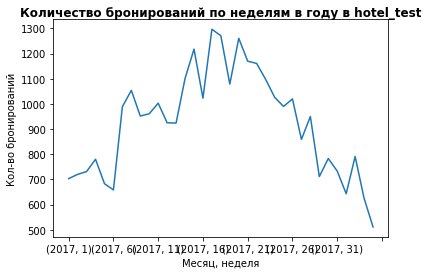

In [40]:

    hotel_test.pivot_table(index=['arrival_date_year', 'arrival_date_week_number'],
                            values='is_canceled', aggfunc='count').plot(legend=None)
    plt.xlabel('Месяц, неделя')
    plt.ylabel('Кол-во бронирований')
    plt.title(label='Количество бронирований по неделям в году в hotel_test' , 
          fontweight="bold", 
          pad='2.0',
          )
    plt.show() 

Можно отметить пик бронирования в середина года.

**Вывод**
- пропуски в столбцах 'meal', 'distribution_channel' заполнили нулями
- После удаления столбца id обнаружилось значительно количество полных дубликатов. Выяснить мы никак не можем, поэтому данные не удаляем
- пик бронирвания в середине года

**Исследовательский анализ целевоо признака**

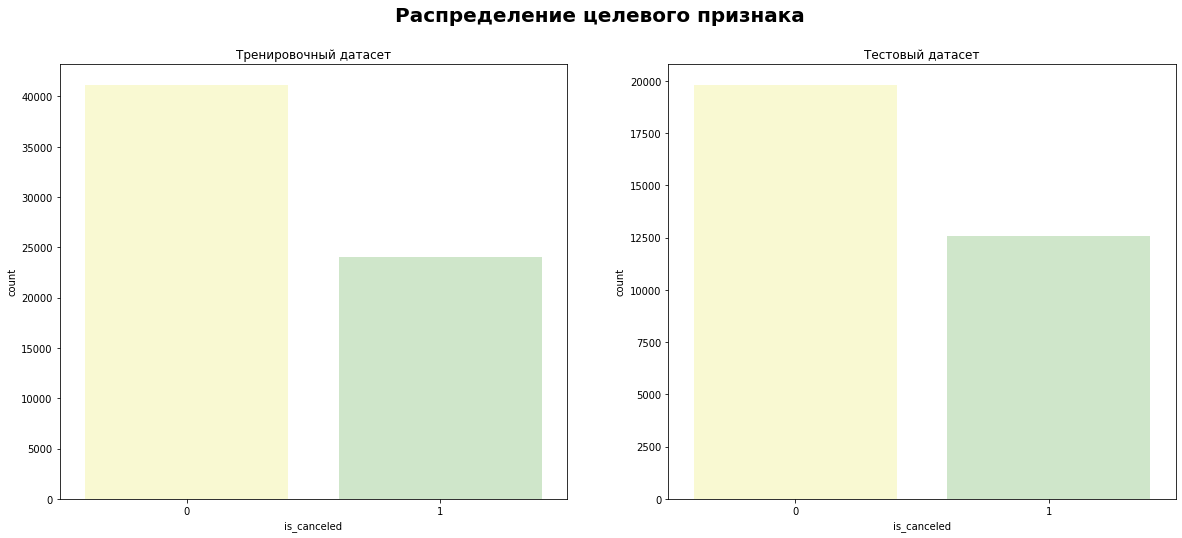

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].set_title('Тренировочный датасет')
axes[1].set_title('Тестовый датасет')
sns.countplot(data = hotel_train , x='is_canceled' , ax=axes[0] , palette= 'Pastel1_r')

sns.countplot(data = hotel_test , x='is_canceled' , ax=axes[1] , palette='Pastel1_r')
fig.suptitle("Распределение целевого признака", fontsize = 20, fontweight="bold" )

plt.show()

In [42]:
print(f"Тренировочный датасет, Остались: {1 - hotel_train['is_canceled'].mean():.2%}, Отменили: {hotel_train['is_canceled'].mean():.2%}")
print(f"Тестовый датасет, Остались : {1 - hotel_test['is_canceled'].mean():.2%}, Отменили: {hotel_test['is_canceled'].mean():.2%}")

Тренировочный датасет, Остались: 63.13%, Отменили: 36.87%
Тестовый датасет, Остались : 61.14%, Отменили: 38.86%


Можем заметить некритичный дисбаланс целевого признака.

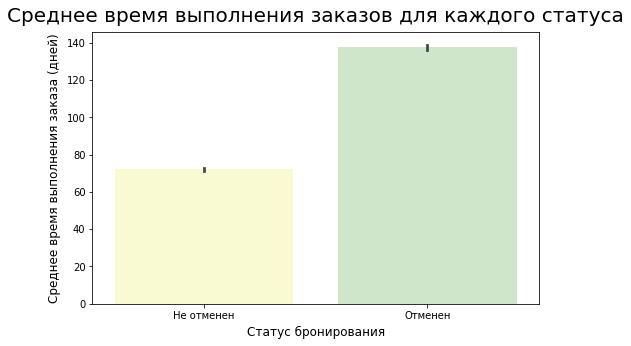

In [43]:
plt.figure(figsize=(8,5)) 
plt.title("Среднее время выполнения заказов для каждого статуса", fontsize = 20, pad = 10)
sns.barplot(x=hotel_train['is_canceled'], y=hotel_train['lead_time'], palette='Pastel1_r')
plt.xlabel("Статус бронирования", fontsize = 12, labelpad = 5)
plt.ylabel("Среднее время выполнения заказа (дней)", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Не отменен', 'Отменен']);
plt.show()

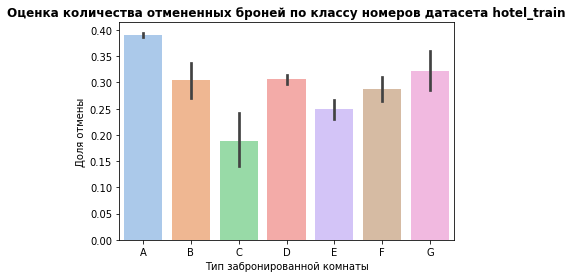

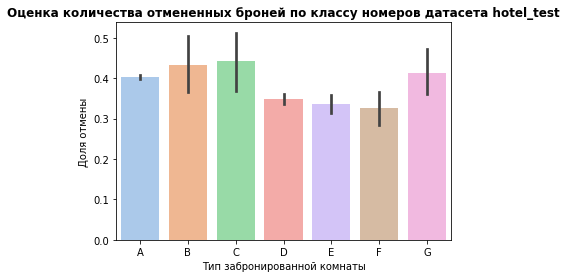

In [44]:
combine_data =[hotel_train, hotel_test]
titles = ['hotel_train', 'hotel_test']
AX = 0
for data in combine_data:
    sns.barplot(data=data, x='reserved_room_type', y='is_canceled', order = ['A','B','C','D','E','F','G'], palette = 'pastel')
    plt.title(f'Оценка количества отмененных броней по классу номеров датасета {titles[AX]}', fontweight="bold")
    plt.xlabel('Тип забронированной комнаты')
    plt.ylabel('Доля отмены')
    AX += 1
    plt.show()

Клиенты, забронировавшие типы номеров A и G, имеют самый высокий процент отмены бронирования. 

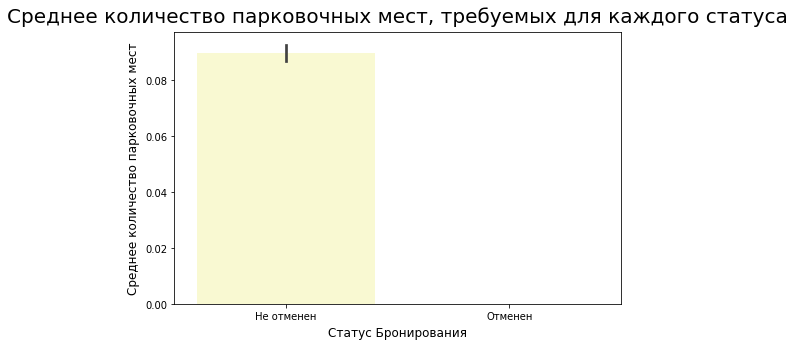

In [45]:
plt.figure(figsize=(8,5)) 
plt.title("Среднее количество парковочных мест, требуемых для каждого статуса", fontsize = 20, pad = 10)
sns.barplot(x=hotel_train['is_canceled'], y=hotel_train['required_car_parking_spaces'], palette='Pastel1_r')
plt.xlabel("Статус Бронирования", fontsize = 12, labelpad = 5)
plt.ylabel("Среднее количество парковочных мест", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Не отменен', 'Отменен'])
plt.show()

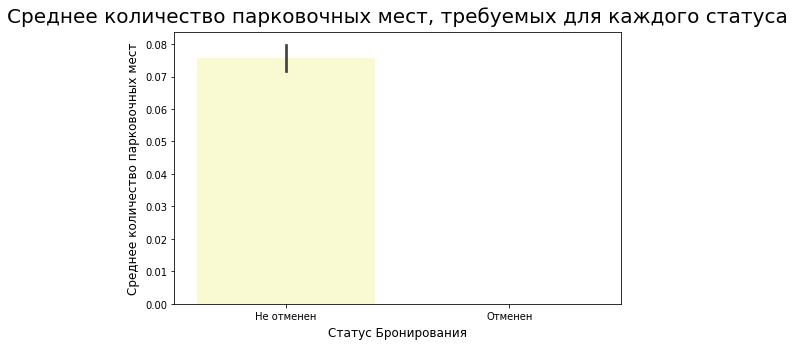

In [46]:
plt.figure(figsize=(8,5)) 
plt.title("Среднее количество парковочных мест, требуемых для каждого статуса", fontsize = 20, pad = 10)
sns.barplot(x=hotel_test['is_canceled'], y=hotel_test['required_car_parking_spaces'], palette='Pastel1_r')
plt.xlabel("Статус Бронирования", fontsize = 12, labelpad = 5)
plt.ylabel("Среднее количество парковочных мест", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Не отменен', 'Отменен'])
plt.show()

Те, кто бронирует парковочные места под авто, почти не отменяют бронирование комнат.

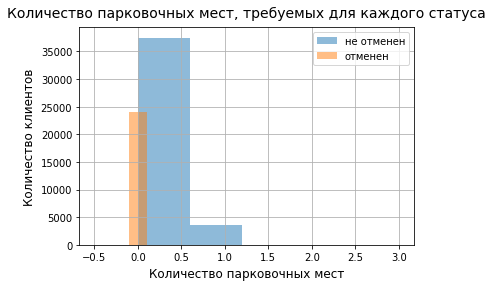

In [47]:
hotel_train.groupby('is_canceled')['required_car_parking_spaces'].hist(bins=5, alpha=0.5)
plt.title('Количество парковочных мест, требуемых для каждого статуса', fontsize = 14, pad = 10)
plt.xlabel('Количество парковочных мест', fontsize = 12, labelpad = 5)
plt.ylabel('Количество клиентов', fontsize = 12, labelpad = 5)
plt.legend((['не отменен', 'отменен']))
plt.show()

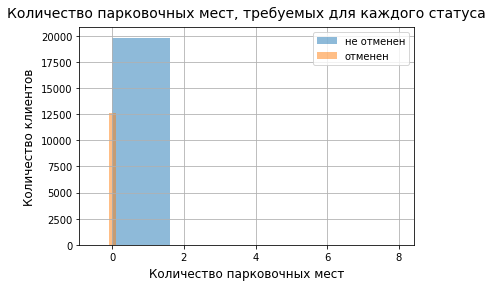

In [48]:
hotel_test.groupby('is_canceled')['required_car_parking_spaces'].hist(bins=5, alpha=0.5)
plt.title('Количество парковочных мест, требуемых для каждого статуса', fontsize = 14, pad = 10)
plt.xlabel('Количество парковочных мест', fontsize = 12, labelpad = 5)
plt.ylabel('Количество клиентов', fontsize = 12, labelpad = 5)
plt.legend((['не отменен', 'отменен']))
plt.show()

В среднем клиентам, которые не отменяют свои бронирования, как правило, требуется больше парковочных мест.

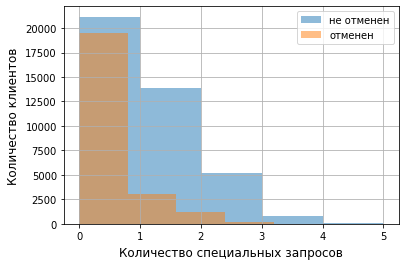

In [49]:
hotel_train.groupby('is_canceled')['total_of_special_requests'].hist(bins=5, alpha=0.5)
plt.xlabel('Количество специальных запросов',fontsize = 12, labelpad = 5)
plt.ylabel('Количество клиентов',fontsize = 12, labelpad = 5)
plt.legend((['не отменен', 'отменен']))
plt.show()

Из графика можно увидеать, что для отмененных и для не отмененных заказов больше всего клиентов с 0 спецаильных запросов, чуть меньше с 1 специальным запросом и т.д

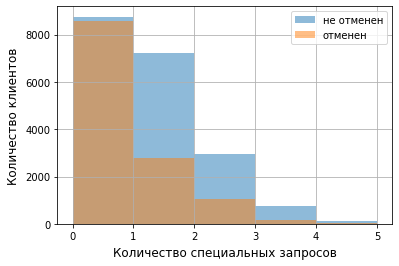

In [50]:
hotel_test.groupby('is_canceled')['total_of_special_requests'].hist(bins=5, alpha=0.5)
plt.xlabel('Количество специальных запросов',fontsize = 12, labelpad = 5)
plt.ylabel('Количество клиентов',fontsize = 12, labelpad = 5)
plt.legend((['не отменен', 'отменен']))
plt.show()

Из графика можно увидеать, что для отмененных и для не отмененных заказов больше всего клиентов с 0 спецаильных запросов, чуть меньше с 1 специальным запросом и т.д

**Вывод**

Примерно 37-39 % бронированний было отменено.

Те, кто бронирует парковочные места под авто, почти не отменяют бронирование комнат.

Класс номеров A и G отменяются чаще всего, тогда как E и F подвержены отмене меньше всего.

Положительно на ситуацию с отменой брони влияют такие показатели как: 
* количество специальных отметок ;
* необходимость места для автомобиля ;
* количество изменений параметров заказа ;
* количество подтверждённых заказов у клиента.

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

In [51]:
#basemap = folium.Map()
#g_m = px.choropleth(hotel_train, locations = hotel_train['country'],
                   #color = hotel_train['is_canceled'],
                   #hover_name = hotel_train['country'])
#g_m.show()    

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца. 


В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня. 

Стоимость номеров отеля:

категория A: за ночь — 1 000, разовое обслуживание — 400;

категория B: за ночь — 800, разовое обслуживание — 350;

категория C: за ночь — 600, разовое обслуживание — 350;

категория D: за ночь — 550, разовое обслуживание — 150;

категория E: за ночь — 500, разовое обслуживание — 150;

категория F: за ночь — 450, разовое обслуживание — 150;

категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.

Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период.

Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.


**Создадим отдельный датасет для выручки**

In [52]:
#Создадим отдельный дф с нужными признаками
df_prof = hotel_test[['is_canceled', 'arrival_date_month', 'reserved_room_type', 'total_nights']]
df_prof.head()

,is_canceled,arrival_date_month,reserved_room_type,total_nights
0,1,January,A,1
1,1,January,A,4
2,1,January,A,4
3,1,January,A,4
4,1,January,A,7


Cоздадим словарик 

In [53]:
room_dict = pd.DataFrame({'reserved_room_type' : ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
                         'price_per_night' : [1000, 800, 600, 550, 500, 450, 350],
                         'service_price' : [400, 350, 350, 150, 150, 150, 150]})

In [54]:
room_dict

,reserved_room_type,price_per_night,service_price
0,A,1000,400
1,B,800,350
2,C,600,350
3,D,550,150
4,E,500,150
5,F,450,150
6,G,350,150


Присоединим словарики к датасету

In [55]:
df_prof= df_prof.merge(room_dict,how='left',on='reserved_room_type')

In [56]:
dict_coef = pd.DataFrame.from_dict({'arrival_date_month' : ['January', 'February', 'March', 'April', 'May', 'June', 
                                    'July', 'August', 'September','October', 'November', 'December'], 
                            'k': [1.0, 1.0, 1.2, 1.2, 1.2, 1.4, 1.4, 1.4, .2, 1.2, 1.2, 1.0]},
                             )



In [57]:
dict_coef.tail

<bound method NDFrame.tail of    arrival_date_month    k
0             January  1.0
1            February  1.0
2               March  1.2
3               April  1.2
4                 May  1.2
5                June  1.4
6                July  1.4
7              August  1.4
8           September  0.2
9             October  1.2
10           November  1.2
11           December  1.0>

In [58]:
df_prof = df_prof.merge(dict_coef,how='left',on='arrival_date_month')

In [59]:
df_prof.head(3)

,is_canceled,arrival_date_month,reserved_room_type,total_nights,price_per_night,service_price,k
0,1,January,A,1,1000,400,1.0
1,1,January,A,4,1000,400,1.0
2,1,January,A,4,1000,400,1.0


In [60]:
#Далее создадим функцию для рассчета прибыли и убытка в зависимости от отмены брони
def profit(row):
    if row['is_canceled'] == 0:
        income = row['price_per_night'] * row['k'] * row['total_nights']
        expens = row['service_price'] * (1 + row['total_nights'] // 2)
    else:
        income = 0
        expens = row['service_price'] + (row['price_per_night'] * row['k'])
    profit = income - expens
    return profit

In [61]:
df_prof['total_profit'] = df_prof.apply(profit, axis=1)

In [62]:
print('Выручка без внедрения депозита составляет:',df_prof['total_profit'].sum())

Выручка без внедрения депозита составляет: 32561070.0


### Шаг 4. Разработка модели ML

Кодируем данные 

In [63]:
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)
feature_arr = ohe.fit_transform(hotel_train[hotel_train.select_dtypes(include=['object']).columns])
feature_labels = ohe.get_feature_names(hotel_train.select_dtypes(include = ['object']).columns)
ohe_train = pd.DataFrame(feature_arr, columns=feature_labels)

In [64]:
features_arr = ohe.transform(hotel_test[hotel_test.select_dtypes(include=['object']).columns])
ohe_test = pd.DataFrame(features_arr,columns=feature_labels)

In [65]:
print('Кол-во строк и столбцов в ohe обучающей выборке:', ohe_train.shape)
print('Кол-во строк и столбцов в ohe тестовой выборке:', ohe_test.shape)

Кол-во строк и столбцов в ohe обучающей выборке: (65211, 186)
Кол-во строк и столбцов в ohe тестовой выборке: (32405, 186)


Соединяем закодированные данные и незакодированные. Для этого:

* Создаем датасет с категориальными незакадированными данными;
* Создаем новый датасет из объединенных данных.

In [66]:
int_train= hotel_train[hotel_train.select_dtypes(include='int').columns]

In [67]:
int_train.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,7,2015,27,1,0,1,1,0,0,0,0,0,0,0,0,0,1
1,0,14,2015,27,1,0,2,2,0,0,0,0,0,0,0,0,1,2
2,0,0,2015,27,1,0,2,2,0,0,0,0,0,0,0,0,0,2
3,0,9,2015,27,1,0,2,2,0,0,0,0,0,0,0,0,1,2
4,1,85,2015,27,1,0,3,2,0,0,0,0,0,0,0,0,1,3


In [68]:
int_test = hotel_test[hotel_test.select_dtypes(include='int').columns]

In [69]:
int_test.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
0,1,74,2017,1,1,1,0,2,0,0,0,0,0,0,0,0,0,1
1,1,62,2017,1,1,2,2,2,0,0,0,0,0,0,0,0,1,4
2,1,62,2017,1,1,2,2,2,0,0,0,0,0,0,0,0,1,4
3,1,71,2017,1,1,2,2,1,0,0,0,0,0,0,0,0,1,4
4,1,172,2017,1,1,2,5,2,0,0,0,0,0,0,0,0,0,7


In [70]:
print('Кол-во строк и столбцов в обучающей выборке:', int_train.shape)
print('Кол-во строк и столбцов в тестовой выборке:', int_test.shape)

Кол-во строк и столбцов в обучающей выборке: (65211, 18)
Кол-во строк и столбцов в тестовой выборке: (32405, 18)


In [71]:
ohe_train = pd.merge(int_train,ohe_train, left_index=True, right_index=True)

In [72]:
ohe_train.head(3)

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_BB,meal_FB,meal_HB,meal_SC,country_ABW,country_AGO,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ATA,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FRA,country_GAB,country_GBR,country_GEO,country_GGY,country_GIB,country_GLP,country_GNB,country_GRC,country_GUY,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KHM,country_KNA,country_KOR,country_KWT,country_LBN,country_LBY,country_LCA,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MMR,country_MNE,country_MOZ,country_MUS,country_MWI,country_MYS,country_NAM,country_NGA,country_NIC,country_NLD,country_NOR,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SEN,country_SGP,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_URY,country_USA,country_UZB,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,7,2015,27,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,14,2015,27,1,0,2,2,0,0,0,0,0,0,0,0,1,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0

In [73]:
ohe_test = pd.merge(int_test,ohe_test, left_index=True, right_index=True)

In [74]:
ohe_test.head(3)

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_BB,meal_FB,meal_HB,meal_SC,country_ABW,country_AGO,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ATA,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FRA,country_GAB,country_GBR,country_GEO,country_GGY,country_GIB,country_GLP,country_GNB,country_GRC,country_GUY,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KHM,country_KNA,country_KOR,country_KWT,country_LBN,country_LBY,country_LCA,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MMR,country_MNE,country_MOZ,country_MUS,country_MWI,country_MYS,country_NAM,country_NGA,country_NIC,country_NLD,country_NOR,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SEN,country_SGP,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_URY,country_USA,country_UZB,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,1,74,2017,1,1,1,0,2,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,62,2017,1,1,2,2,2,0,0,0,0,0,0,0,0,1,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [75]:
print('Кол-во строк и столбцов в ohe обучающей выборке:', ohe_train.shape)
print('Кол-во строк и столбцов в ohe тестовой выборке:', ohe_test.shape)

Кол-во строк и столбцов в ohe обучающей выборке: (65211, 204)
Кол-во строк и столбцов в ohe тестовой выборке: (32405, 204)


Разделим на обучающие признаки и целевые.

In [76]:
features_train, target_train = ohe_train.drop(columns='is_canceled', axis=1), ohe_train['is_canceled']
features_test, target_test = ohe_test.drop(columns='is_canceled', axis=1), ohe_test['is_canceled']

In [77]:
display(features_train)

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_BB,meal_FB,meal_HB,meal_SC,country_ABW,country_AGO,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ATA,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FRA,country_GAB,country_GBR,country_GEO,country_GGY,country_GIB,country_GLP,country_GNB,country_GRC,country_GUY,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KHM,country_KNA,country_KOR,country_KWT,country_LBN,country_LBY,country_LCA,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MMR,country_MNE,country_MOZ,country_MUS,country_MWI,country_MYS,country_NAM,country_NGA,country_NIC,country_NLD,country_NOR,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SEN,country_SGP,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_URY,country_USA,country_UZB,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,7,2015,27,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,14,2015,27,1,0,2,2,0,0,0,0,0,0,0,0,1,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0

In [78]:
#Масштабируем числ признаки обучающей выборки
numeric = [*features_train.select_dtypes(exclude=['object']).columns]
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])


In [79]:
display(features_train)

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_BB,meal_FB,meal_HB,meal_SC,country_ABW,country_AGO,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ATA,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FRA,country_GAB,country_GBR,country_GEO,country_GGY,country_GIB,country_GLP,country_GNB,country_GRC,country_GUY,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KHM,country_KNA,country_KOR,country_KWT,country_LBN,country_LBY,country_LCA,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MMR,country_MNE,country_MOZ,country_MUS,country_MWI,country_MYS,country_NAM,country_NGA,country_NIC,country_NLD,country_NOR,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SEN,country_SGP,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_URY,country_USA,country_UZB,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,-0.929404,-1.599557,-0.322241,-1.697274,-0.966795,-0.903755,-1.746333,-0.223988,-0.072962,-0.167033,-0.133565,-0.081193,-0.326884,-0.18284,-0.244069,-0.681232,-1.179388,-0.281974,-0.337659,-0.303316,-0.232966,-0.17286,3.225912,-0.277352,-0.260634,-0.277897,-0.311147,-0.406691,-0.394499,0.511424,-0.083452,-0.354824,-0.311770,-0.003916,-0.046384,-0.010361,-0.003916,-0.019972,-0.04054,-0.009593,-0.003916,-0.050822,-0.105364,-0.011749,-0.003916,-0.139512,-0.003916,-0.003916,-0.011749,-0.027141,-0.003916,-0.012384,-0.012989,-0.011749,-0.130198,-0.007832,-0.003916,-0.116418,-0.025387,-0.090176,-0.005538,-0.009593,-0.086832,-0.023502,-0.015168,-0.013567,-0.003916,-0.003916,-0.016616,-0.041478,-0.251763,-0.003916,-0.055604,-0.006783,-0.030849,-0.012384,-0.019188,-0.285005,-0.026278,-0.003916,-0.060905,-0.317538,-0.006783,3.429861,-0.012384,-0.006783,-0.012384,-0.005538,-0.009593,-0.035266,-0.003916,-0.015666,-0.003916,-0.028788,-0.043116,-0.017072,-0.003916,-0.03676,-0.150536,-0.02825,-0.013567,-0.017948,-0.076051,-0.192323,-0.005538,-0.008757,-0.013567,-0.042396,-0.012384,-0.005538,-0.005538,-0.003916,-0

#### Выбор лучшей модели ####

Наша цель - предсказать отмену номеров, другими словами, нам нужно максимизировать обнаружение положительных примеров, которые действительно относятся к положительному классу. Для этого нужно использовать метрику **recall**.

**Logistic Regression**

In [80]:
lg_params = {
    'penalty':['l1','l2'],
    'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver':['saga']}

lg_gs = GridSearchCV(LogisticRegression(solver='liblinear', random_state=42),
                 lg_params,
                 cv = 5,
                 scoring = 'recall')
lg = lg_gs.fit(features_train, target_train)


In [81]:
print('Оптимальные параметры: ',lg.best_params_)

Оптимальные параметры:  {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}


In [82]:
#lg.best_estimator_.fit(features_train, target_train)
predicted_lg = lg.best_estimator_.predict(features_test)

In [83]:
recall_lg = lg.best_score_ 

In [84]:
print(f'Лучший recall на выборке: {recall_lg}')

Лучший recall на выборке: 0.4957298243829425


**Decision Tree**

In [85]:
dt_params = {
    'max_depth': [2, 4, 8, 16],
    'min_samples_split': range(5,55,10), 
    'min_samples_leaf': [2, 3, 5, 10],
    'class_weight':['balanced']
}
dt_gs = GridSearchCV(DecisionTreeClassifier(random_state=42),
                         dt_params, n_jobs=-1,cv = 5,scoring = 'recall',
                         return_train_score=True)
dt = dt_gs.fit(features_train, target_train)

In [86]:
print('Оптимальные параметры: ',dt.best_params_) 

Оптимальные параметры:  {'class_weight': 'balanced', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 5}


In [87]:
recall_dt = dt.best_score_

In [88]:
print(f'Лучший Recall на обучающей выборке: {recall_dt}')

Лучший Recall на обучающей выборке: 0.674253419043398


In [89]:
predicted_dt = dt.best_estimator_.predict(features_test)

**Random Forest**

In [90]:
rf_params = {
    'criterion':['gini','entropy'],
    'n_estimators': [2, 5, 10, 30, 50],
    'max_depth': [2, 4, 8, 16],
    'min_samples_leaf': [2,3,5,10],
    'class_weight':['balanced']
}


rf_gs = GridSearchCV(RandomForestClassifier(random_state=5),
                     rf_params, cv = 5, scoring = 'recall',
                      
                     return_train_score=True,
                     verbose=2)
rf = rf_gs.fit(features_train, target_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
[CV] END class_weight=balanced, criterion=gini, max_depth=2, min_samples_leaf=2, n_estimators=2; total time=   0.1s
[CV] END class_weight=balanced, criterion=gini, max_depth=2, min_samples_leaf=2, n_estimators=2; total time=   0.1s
[CV] END class_weight=balanced, criterion=gini, max_depth=2, min_samples_leaf=2, n_estimators=2; total time=   0.1s
[CV] END class_weight=balanced, criterion=gini, max_depth=2, min_samples_leaf=2, n_estimators=2; total time=   0.1s
[CV] END class_weight=balanced, criterion=gini, max_depth=2, min_samples_leaf=2, n_estimators=2; total time=   0.1s
[CV] END class_weight=balanced, criterion=gini, max_depth=2, min_samples_leaf=2, n_estimators=5; total time=   0.1s
[CV] END class_weight=balanced, criterion=gini, max_depth=2, min_samples_leaf=2, n_estimators=5; total time=   0.1s
[CV] END class_weight=balanced, criterion=gini, max_depth=2, min_samples_leaf=2, n_estimators=5; total time=   0.2s
[CV] END 

In [91]:
print('Оптимальные параметры: ', rf.best_params_) 

Оптимальные параметры:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 10}


In [92]:
recall_rf = rf.best_score_

In [93]:
print(f'Лучший Recall на обучающей выборке: {recall_rf}')


Лучший Recall на обучающей выборке: 0.6054064775246357


In [94]:
predicted_rf = rf.best_estimator_.predict(features_test)

Все метрики уместим в одной компактной таблице. Из них выберем лучшую на основании метрики recall.

In [95]:
best_metrics = pd.DataFrame(data=[('Logistic Regression',round(recall_lg, 3)),
                                 ('Decision Tree', round(recall_dt, 3)), 
                                 ('Random Forest', round(recall_rf, 3))],
                                 columns=['model','recall'])
best_metrics

,model,recall
0,Logistic Regression,0.496
1,Decision Tree,0.674
2,Random Forest,0.605


**Вывод**

Мы пострили три модели, и, как видим, все три достаточно работоспособны. 

- Логистическая регрессия. Показатель recall 0.49 на кросс валидации, Оптимальные параметры:  'C': 0.001, 'penalty': 'l1', 'solver': 'saga'.


- Дерево решений с параметрами: (class_weight': 'balanced', 'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 5). Показатель recall: 0.675.


- Cлучайный лес с параметрами:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 10}. Показатель Recall: 0.6.


Как видим по показателям нас устраивает модель Decision Tree.




**Оценим выручку после обучения моделей с внедрением депозитов**

In [96]:
df_prof['ml_pred_rf'] = predicted_rf

In [97]:
df_prof

,is_canceled,arrival_date_month,reserved_room_type,total_nights,price_per_night,service_price,k,total_profit,ml_pred_rf
0,1,January,A,1,1000,400,1.0,-1400.0,1
1,1,January,A,4,1000,400,1.0,-1400.0,0
2,1,January,A,4,1000,400,1.0,-1400.0,0
3,1,January,A,4,1000,400,1.0,-1400.0,1
4,1,January,A,7,1000,400,1.0,-1400.0,1
...,...,...,...,...,...,...,...,...,...
32400,0,August,A,6,1000,400,1.4,6800.0,1
32401,0,August,A,7,1000,400,1.4,8200.0,0
32402,0,August,A,7,1000,400,1.4,8200.0,1
32403,0,August,D,7,550,150,1.4,4790.0,0


In [98]:
df_prof['ml_pred_lg'] = predicted_lg

In [99]:
df_prof['ml_pred_dt'] = predicted_dt

In [100]:
df_prof

,is_canceled,arrival_date_month,reserved_room_type,total_nights,price_per_night,service_price,k,total_profit,ml_pred_rf,ml_pred_lg,ml_pred_dt
0,1,January,A,1,1000,400,1.0,-1400.0,1,1,1
1,1,January,A,4,1000,400,1.0,-1400.0,0,0,0
2,1,January,A,4,1000,400,1.0,-1400.0,0,0,0
3,1,January,A,4,1000,400,1.0,-1400.0,1,1,1
4,1,January,A,7,1000,400,1.0,-1400.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
32400,0,August,A,6,1000,400,1.4,6800.0,1,0,1
32401,0,August,A,7,1000,400,1.4,8200.0,0,0,0
32402,0,August,A,7,1000,400,1.4,8200.0,1,0,1
32403,0,August,D,7,550,150,1.4,4790.0,0,0,0


In [101]:
def profit_pred(row, col):
    if row['is_canceled']==0:
        income = row['price_per_night']*row['total_nights']*row['k']
        expens = row['service_price']*round(1 + row['total_nights']/2) 
    elif (row[col]==0) and (row['is_canceled']==1):
        income = 0
        expens = row['service_price'] + (row['price_per_night'] * row['k'])
    elif (row[col]==1) and (row['is_canceled']==1):
        income= (row['price_per_night']*0.8 * row['k'] ) + row['service_price'] * 0.8 
        expens = row['service_price'] + (row['price_per_night'] * row['k'])
    profit_pred = income - expens
    return profit_pred

In [102]:
df_prof['profit_pred_lg'] = df_prof.apply(profit_pred, col='ml_pred_lg', axis=1)
df_prof['profit_pred_dt'] = df_prof.apply(profit_pred, col='ml_pred_dt', axis=1)
df_prof['profit_pred_rf'] = df_prof.apply(profit_pred, col='ml_pred_rf', axis=1)

In [103]:
print('Выручка после обучения модели Logistic Regression:',df_prof['profit_pred_lg'].sum())
print('Выручка после обучения модели Decision Tree:',df_prof['profit_pred_dt'].sum())
print('Выручка после обучения модели Random Forest:',df_prof['profit_pred_rf'].sum())

Выручка после обучения модели Logistic Regression: 37679816.0
Выручка после обучения модели Decision Tree: 40558448.0
Выручка после обучения модели Random Forest: 40031664.0


In [104]:
print('Прибыль от использования Logistic Regression:', (df_prof['profit_pred_lg'].sum() - df_prof['total_profit'].sum()))
print('Прибыль от использования Decision Tree::', (df_prof['profit_pred_dt'].sum() - df_prof['total_profit'].sum()))
print('Прибыль от использования Random Forest:', (df_prof['profit_pred_rf'].sum() - df_prof['total_profit'].sum()))

Прибыль от использования Logistic Regression: 5118746.0
Прибыль от использования Decision Tree:: 7997378.0
Прибыль от использования Random Forest: 7470594.0


Как видим, нас больше всего устраивает модель Decision Tree. Она могла бы принести более 24 млн руб дополнительной прибыли за отчетный период,

### Шаг 5. Опишите портрет «ненадёжного» клиента

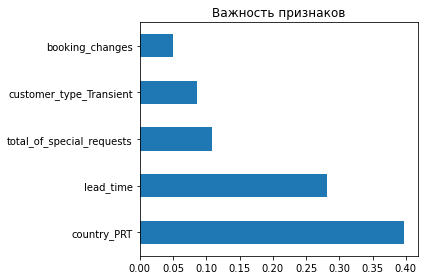

In [105]:
#Посмотрим, какие признаки выделила наша модель
pd.Series(dt.best_estimator_.feature_importances_, features_train.columns).nlargest(5).plot(kind='barh')
plt.title('Важность признаков')

plt.tight_layout()
plt.show()

In [106]:
predicted_dt= pd.Series(predicted_dt).to_frame()
predicted_dt.columns = ['predicted_dt']
hotel_test = hotel_test.merge(predicted_dt, left_index=True, right_index=True)
hotel_test

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,predicted_dt
0,1,74,2017,January,1,1,1,0,2,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1
1,1,62,2017,January,1,1,2,2,2,0,0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,0
2,1,62,2017,January,1,1,2,2,2,0,0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,0
3,1,71,2017,January,1,1,2,2,1,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1
4,1,172,2017,January,1,1,2,5,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32400,0,164,2017,August,35,31,2,4,2,0,0,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,0,6,1
32401,0,21,2017,August,35,30,2,5,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,2,7,0
32402,0,23,2017,August,35,30,2,5,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1
32403,0,34,2017,August,35,31,2,5,2,0,0,BB,DEU,TA/TO,0,0,0,D,0,0,Transient,0,4,7,0


In [107]:

сat_cols = ['customer_type', 'meal', 'distribution_channel', 'reserved_room_type']

def comparison(col):
            fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
            sns.barplot(data=hotel_test, x=col, y='is_canceled', ax=ax[0], palette = 'Pastel1_r')
            ax[0].set_title('Фактические отмены')
            ax[0].set_ylabel('Зависимость признака')
            sns.barplot(data=hotel_test, x=col, y='predicted_dt', ax=ax[1], palette = 'Pastel1_r')
            ax[1].set_title('Предсказанные отмены')
            ax[1].set_ylabel('Зависимость  признака')
        
            plt.show()

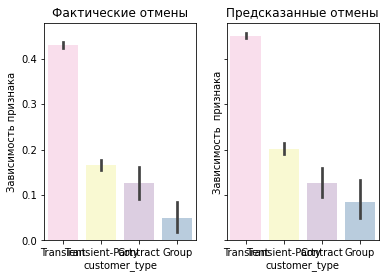

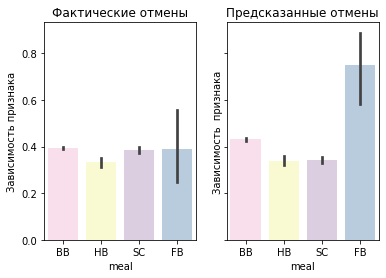

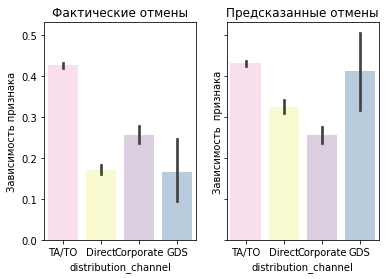

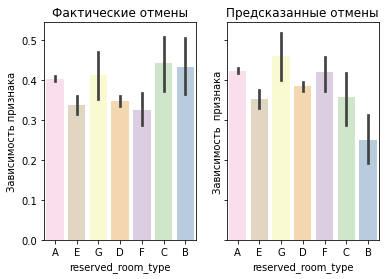

In [108]:
for col in сat_cols:
    comparison(col)

**Вывод**




1. Во-первых, одним из главных факторов отмены можно назвать времяннной промежуток между датой бронированием и заездом в отель. Чем боьше этот промежуток, тем выше шанс отказа.
2. Стоит отметить благоприятные факторы, которые снижают вероятность отмены, напрмер:
* долгие взаимоотношения с отелем;
* наличие уже осуществленных бронирований ранее;
* предзаказанные места на парковке и тд.


3. Забронированные группами или юрлицами места реже подвергаются отменам. Как и номера категории E, D, F.
4. Гости из Португалии имеют тенценцию к отмене бронирования.


### Шаг 6. Напишите общий вывод

Мы провели предобработку данных, удалили  столбец id, , выявили дубликаты, которые решено было оставить, тк мы не знаем причину их появления. Также исправили категориальные значения, в которых были ошибки и удалили единичные строки с нулевым количеством постояльцев.

В исследовательском анализе мы выявили, что отменяется 37-39 % брони.

Выявили, что пик бронирований приходится на середину года, тогда как в начале и в конце возможны снижения из-за сезонности.

Далее провели масштабирование и кодирование через OneHotEncoding  тренировочноq выборки. 

Далее мы обучили наши модели. Выбрали три: лог регрессия, дерево решений, случайный лес.

Оценивая портрет "ненадежного" клиента пришли к выводу, что на ненадежность очень сильно влияет время ожидания между датой бронирования и заездом в отель.В то же время долгие взаимоотношения с отелем, наличие уже осуществленных бронирований ранее, специальные отметки, предзаказанные места на парковке и тд. выявляют серьезные намерения у клиента. 

Гости из Португалии имеют тенценцию к отмене бронирования. Они составляют значительную долю бронирований в отеле, но и часто (около половины общего количества) их отменяют. 

Из полученных данных можно сделать вывод, что  наиболее оптимальные параметры у модели Дерево решений и лучше выбрать именно её. 

Модель Decision Tree: редсказывает прибыль 7 997 378 и принесёт компании выручку 